# Image Segmentation with a U-Net-like Architecture

*This tutorial was adapted from the Code examples of Image Segmentation available in Keras documentation.*

---


## Downloading the Data

*   We will use [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset for this tutorial
*   First we will fetch the zipped folders and unzip them in our local folder
*   *Remember the files will be available only in the scope of the notebook and would not be available after the connection is terminated*

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0   102M      0  0:00:07  0:00:07 --:--:--  104M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  49.2M      0 --:--:-- --:--:-- --:--:-- 49.2M


## Preparing the paths of Input images and Target segmentation masks

*   We iterate the folders and create list of images and the corresponding masks.

In [2]:
# Constants

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160) 
num_classes = 3  # this defines the number of classes available in the target mask
batch_size = 32

In [3]:
import os

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of target masks:", len(target_img_paths))

print("Printing the paths of 10 image-mask pairs")
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
Number of target masks: 7390
Printing the paths of 10 image-mask pairs
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Visualizing Images and Masks

*   We visualize an input image and corresponding segmentation mask
*   Note that we will use auto-contrast function to visualize the mask. The masks can also be visualized using simple grayscale images or color images.

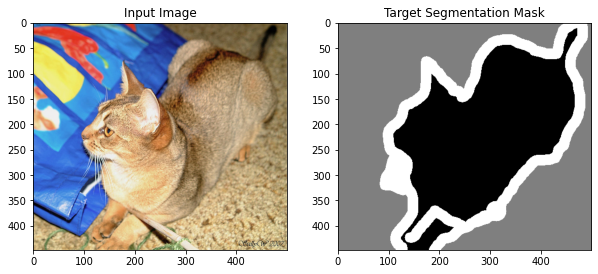

In [4]:
import matplotlib.pyplot as plt

# we are using load_img available in keras directly
from tensorflow.keras.preprocessing.image import load_img
from PIL.ImageOps import autocontrast

f, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(load_img(input_img_paths[9]))
axes[0].set_title('Input Image')

# Display auto-contrast version of corresponding target (per-pixel categories)
axes[1].imshow(autocontrast(load_img(target_img_paths[9])))
axes[1].set_title('Target Segmentation Mask')

plt.show()

## Preparing Sequence class to load & vectorize batches of data

*   Sequence class is the base object available in keras for fitting any sequence data such as a dataset.
*   We will create an inherited class from the base Sequence class for our dataset.
*   Note that all Sequence classes should have a \_\_len\_\_ method and \_\_getitem\_\_ method

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Preparing U-Net Xception-style model

*   Now we will define the U-Net architecture.

In [6]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [7]:
# We will free up the RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

*  We will use the get_model method to build the model

In [8]:
# Build model
model = get_model(img_size, num_classes)

In [9]:
#To see the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Creating a validation split

*   The dataset does not contain a validation split by default. So we will create a validation data of 1000 samples
*   Note the usage of shuffle and random to get the samples

In [10]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Training the model

*   The training process is similar to other model training - first we compile the model, define callbacks and use fit method to train the model.

In [11]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - ETA: 0s - loss: 0.8891

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


199/199 [==============================] - 102s 433ms/step - loss: 0.8891 - val_loss: 2.1882
Epoch 2/15
199/199 [==============================] - 86s 433ms/step - loss: 0.4975 - val_loss: 1.7977
Epoch 3/15
199/199 [==============================] - 86s 431ms/step - loss: 0.4240 - val_loss: 0.4524
Epoch 4/15
199/199 [==============================] - 85s 429ms/step - loss: 0.3790 - val_loss: 0.4333
Epoch 5/15
199/199 [==============================] - 87s 434ms/step - loss: 0.3479 - val_loss: 0.3789
Epoch 6/15
199/199 [==============================] - 89s 448ms/step - loss: 0.3166 - val_loss: 0.3722
Epoch 7/15
199/199 [==============================] - 86s 434ms/step - loss: 0.2936 - val_loss: 0.4215
Epoch 8/15
199/199 [==============================] - 85s 427ms/step - loss: 0.2714 - val_loss: 0.3932
Epoch 9/15
199/199 [==============================] - 85s 428ms/step - loss: 0.2533 - val_loss: 0.3953
Epoch 10/15
199/199 [==============================] - 85s 428ms/step - loss: 0.237

## Visualizing predictions

*   Generating predictions for all images in the validation set

In [12]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

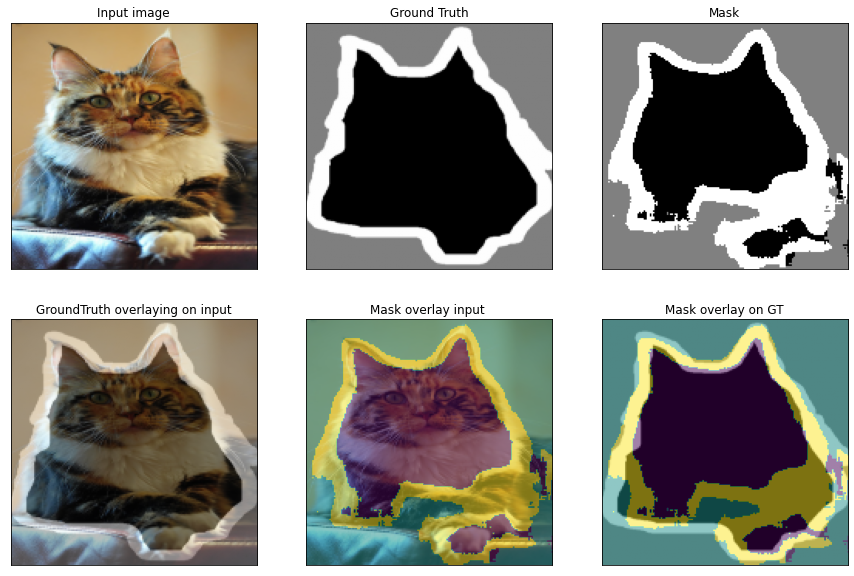

In [13]:
from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize

i = 15 # validation image index to display results 

f, axs = plt.subplots(2, 3, figsize=(15, 10))

img1 = imread(val_input_img_paths[i])
img1 = resize(img1, (160, 160))
img2 = autocontrast(load_img(val_target_img_paths[i]))
img2 = resize(np.array(img2), (160, 160))
img3 = np.argmax(val_preds[i], axis=-1)

axs[0][0].imshow(img1)
axs[0][0].set_title('Input image')
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])

axs[0][1].imshow(img2)
axs[0][1].set_title('Ground Truth')
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])

axs[0][2].imshow(img3, cmap="gray")
axs[0][2].set_title('Mask')
axs[0][2].set_xticks([])
axs[0][2].set_yticks([])

background = imread(val_input_img_paths[i])
background = resize(background, (160, 160))

axs[1][0].imshow(background)
axs[1][0].imshow(img2, alpha=0.5)
axs[1][0].set_title('GroundTruth overlaying on input')
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])

background = imread(val_input_img_paths[i])
background = resize(background, (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][1].imshow(background)
axs[1][1].imshow(mask, alpha=0.5)
axs[1][1].set_title('Mask overlay input ')
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])

background = autocontrast(load_img(val_target_img_paths[i]))
background = resize(np.array(background), (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][2].imshow(background)
axs[1][2].imshow(mask, alpha=0.5)
axs[1][2].set_title('Mask overlay on GT')
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])

plt.show()

## Quantitative Measures using Jaccard Score

*   We will compare the target masks and the prediction masks using Jaccard Score.
*   Note that Jaccard score will work only on 1-D arrays.

In [14]:
from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score

g_t = img_as_int(resize(imread(val_target_img_paths[i], as_gray=True), img_size))

print(jaccard_score(g_t.flatten(), mask.flatten(), average='micro'))

0.1914735176393931
